In [34]:
import numpy as np
import math
from tqdm import tqdm
import pandas as pd
from types import MethodType

In [ ]:
class NeuralNetwork:
  '''Neural Network with L layer (Regression or classification)'''
  def __init__(self,layer_sizes,learning_rate=0.01):
    '''Initialising the network
    Input:
    - Layer_sizes(input_sizes,h1,h2,......,Hl-1,Output_size)
    -Learning_rate'''
    self.layer_sizes=layer_sizes
    self.L=len(layer_sizes)-1
    self.lr=learning_rate 
    # initialising the weights
    self.weights={}
    self.biases={}
    self.n_params=0
    self._initialize_network()
  def _initialize_network(self):
    for l in range(1,len(self.layer_sizes)):
        in_dim=self.layer_sizes[l-1]
        out_dim=self.layer_sizes[l]
        self.weights[l]=np.random.randn(in_dim,out_dim)/np.sqrt(in_dim)
        self.biases[l]=np.zeros((1,out_dim))
        self.n_params+=in_dim * out_dim + out_dim
  def evaluate_proposal(self,x_data,theta):
    
     '''Evaluating  a proposed theta (flattened weights + biases)'''
     self.decode(theta)
     N=x_data.shape[0]
     fx=np.zeros((N,self.layer_sizes[-1]))
     for i in range(N):
        fx[i]=self.forward_pass(x_data[i:i+1])
     return fx
  def decode(self,theta):
     ''' Decoding   flat theta vector into weights and biases'''
     self.weights={}
     self.biases={}
     idx=0
     for l in range(1,len(self.layer_sizes)):
        in_dim=self.layer_sizes[l-1]
        out_dim=self.layer_sizes[l]
        w_size=in_dim*out_dim
        b_size=out_dim
        self.weights[l]=theta[idx:idx+w_size].reshape(in_dim,out_dim)
        idx+=w_size
        self.biases[l]=theta[idx:idx+b_size].reshape(1,out_dim)
        idx+=b_size
  def sigmoid(self,x):
     return 1/(1+np.exp(-x))
  def softmax(self,x):
     exp_x=np.exp(x-np.max(x,axis=1,keepdims=True))
     return exp_x/(np.sum(exp_x,axis=1,keepdims=True))
  def encode(self):
     '''Encode all weights and biases into a single 1D parameter vector (theta)'''
     theta_parts=[]
     for l in range(1,self.L+1):
        w=self.weights[l].ravel()
        b=self.biases[l].ravel()
        theta_parts.extend([w,b])
     theta=np.concatenate(theta_parts)
     return theta
  def langevin_gradient(self,x_data,y_data,theta,depth):
     '''
    Here we are Computing the Langevin gradient-based parameter update using SGD
    Parameters:
        x_data : np.array (N x features)
        y_data : np.array (N,)
        theta  : np.array, current flattened parameter vector
        depth  : int, number of SGD steps (depth of update)

    Returns:
        theta_updated : np.array, updated flattened parameters
    '''
     self.decode(theta)
     N=x_data.shape[0]
     for _ in range(depth):
        for i in range(N):
           x_i=x_data[i:i+1]
           y_i=y_data[i:i+1]
           self.forward_pass(x_i)
           self.backward_pass(x_i,y_i)
     theta_updated=self.encode()
     return theta_updated
  def forward_pass(self,x):
     '''Perform the forward propagation and return y_pred after softmax '''
     self.layer_input={}
     self.layer_activation={}
     self.layer_activation[0]=x
     for l in range(1,self.L+1):
        z=np.dot(self.layer_activation[l-1],self.weights[l])+self.biases[l]
        self.layer_input[l]=z
        if l==self.L:
           self.layer_activation[l]=self.softmax(z)
        else:
           self.layer_activation[l]=self.sigmoid(z)
     return self.layer_activation[self.L]
  def backward_pass(self,x,y):
     '''Back Propagation'''
     if y.ndim==0 or y.shape==():
        y=np.eye(self.layer_sizes[-1])[int(y)].reshape(1,-1)
     grad_w={}
     grad_b={}
     delta=self.layer_activation[self.L]-y # softmax plus cross entropy 
     for  l in range(1,self.L+1):
        a_prev=self.layer_activation[l-1]
        grad_w[l]=np.dot(a_prev.T,delta)
        grad_b[l]=delta 
        # calculate grad for prev layer
        if l>1:
           dz=self.layer_activation[l-1]*(1-self.layer_activation[l-1])
           delta=np.dot(delta,self.weights[l].T)*dz
      # updating the weights
     for l in range(1,self.L+1):
        self.weights[l]-=self.lr *grad_w[l]
        self.biases[l]-=self.lr *grad_b[l]
    
  

In [ ]:
def likelihood_function(self,theta,tausqr,test=False):
  '''
    Calculate the log likelihood of the data given the parameters
    Input:
        theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
        tausq: variance of the error term
    Output:
        log_likelihood: log likelihood of the data given the parameters
        model_prediction: prediction of the model given the parameters
        accuracy: accuracy (RMSE) of the model given the parameters
    '''
  if test:
        x_data = self.x_test
        y_data = self.y_test
  else:
      x_data = self.x_data
      y_data = self.y_data
   #get the model pred    
  y_pred=self.model.evaluate_proposal(x_data,theta)
  # adding the gaussian noise for simulation 
  model_simulation=y_pred+np.random.normal(0,tausqr,size=y_pred.shape)
  # computing the rmse as it is Regression problem 
  accuracy=self.rmse(y_pred,y_data)
  log_likelihood=np.sum(-0.5 * np.log(2 * np.pi * tausqr) - 0.5 * np.square(y_data - y_pred) / tausqr)
  return [log_likelihood,y_pred,model_simulation,accuracy]
def prior_function(self,sigma_sqr,nu_1,nu_2,theta,tausqr):
    '''
    Calculate the prior of the parameters
    Input:
        sigma_sqr: variance of normal prior for theta
        nu_1: parameter nu_1 of the inverse gamma prior for tau^2
        nu_2: parameter nu_2 of the inverse gamma prior for tau^2
        theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
        tausqr: variance of the error term
    Output:
        log_prior: log prior
    '''
    n_params=self.theta_size 
    part1 = -1 * (n_params / 2) * np.log(sigma_sqr)
    part2 = 1 / (2 * sigma_sqr) * (sum(np.square(theta)))
    log_prior = part1 - part2 - (1 + nu_1) * np.log(tausqr) - (nu_2 / tausqr)
    return log_prior

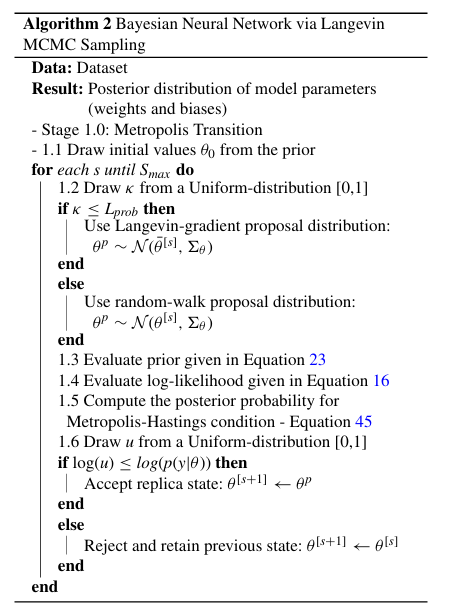

The acceptance probability is :
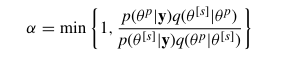

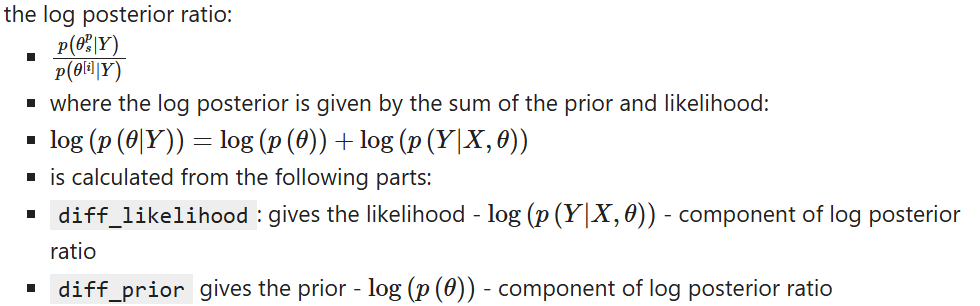

In [37]:
def unpack_theta(self):
  """
    Unpacks self.post_theta into a dictionary of weight and bias samples per layer.
    """
  results_dict={}
  idx=0
  for layer_num in range(len(self.model.layer_size)-1):
    in_dim = self.model.layer_size[layer_num]
    out_dim = self.model.layer_size[layer_num + 1]
    w_size=in_dim*out_dim
    w_samples = self.post_theta[:, idx : idx + w_size]
    results_dict[f'W{layer_num+1}'] = w_samples
    idx += w_size
    b_size = out_dim
    b_samples = self.post_theta[:, idx : idx + b_size]
    results_dict[f'b{layer_num+1}'] = b_samples
    idx += b_size
  results_dict['tau'] = self.post_tau.squeeze()




In [ ]:
def sampler(self):
  '''Run the sampler '''
  # define the empty array to store the sampled posterior values
   # posterior of all weights and biases over all samples
  post_theta=np.ones((self.n_samples,self.theta_size)) 
  # posterior defining the variance of the noise in predictions 
  post_tau=np.ones((self.n_samples,1)) 
  post_eta=np.ones((self.n_samples,1))
  # store output of f(x) over all samples 
  y_pred=np.zeros((self.n_samples,self.x_data.shape[0]))
  # storing the simulated values of f(x)+error over all samples
  y_sim=np.zeros((self.n_samples,self.x_data.shape[0]))
  # store the rmse of each sample
  rmse_data=np.zeros(self.n_samples)
  # similar to above we are going to store  for test as well
  y_pred_test=np.ones((self.n_samples, self.x_test.shape[0]))
  y_sim_test=np.ones((self.n_samples, self.x_test.shape[0]))
  rmse_data_test=np.zeros(self.n_samples)
  ## Initialization process
  theta=np.random.randn(self.theta_size)
  # initial pred 
  y_pred[0]=self.model.evaluate_proposal(self.x_data,theta)
  # eta init
  eta=np.log(np.var(y_pred[0,]-self.y_data)) # log space 
  tau_proposal=np.exp(eta) # back to normal space 
  # Hyperpriors-Initial assumption like our guess that data might be of this form (we can use many techniques here for better model performance): Hyper parameters
  sigma_sqr=self.sigma_sqr
  nu_1=self.nu_1 
  nu_2=self.nu_2
  # Prior
  prior_val=self.prior_function(sigma_sqr,nu_1,nu_2,theta,tau_proposal)
  # Log likelihood given observation
  [likelihood,y_pred[0,],y_sim[0,],rmse_data[0]]=self.likelihood_function(theta,tau_proposal)
  n_accept=0
  n_langevin=0
  # Sampling by MCMC for n_samples each time one
  for i in tqdm(np.arange(1,self.n_samples)):
    #new values for theta and tau
    theta_proposal=theta+np.random.normal(0,self.step_theta,self.theta_size)
    # updating the theta_proposal using langevin gradient for better and fast result
    lx=np.random.uniform(0,1,1)
    if(self.use_langevin_gradient is True)and(lx<self.l_prob):
      theta_gd=self.model.langevin_gradient(self.x_data,self.y_data,theta.copy(),self.sgd_depth)
      theta_proposal=np.random.normal(theta_gd,self.step_theta,self.theta_size)
      theta_proposal_gd=self.model.langevin_gradient(self.x_data,self.y_data,theta_proposal.copy(),self.sgd_depth)
      wc_delta=(theta-theta_proposal_gd)
      wp_delta=(theta_proposal-theta_gd)
      sigma_sq=self.step_theta

      part1=-0.5 * np.sum(wc_delta * wc_delta) / sigma_sq #wc_delta.T  *  wc_delta /sigma_sq
      part2= -0.5 * np.sum(wp_delta * wp_delta) / sigma_sq
      diff_prop=part1-part2
      n_langevin+=1
    else:
      diff_prop=0
      theta_proposal=np.random.normal(theta, self.step_theta, self.theta_size)

    #eta proposal
    eta_proposal=eta+np.random.normal(0,self.step_eta,1)
    tau_proposal=np.exp(eta_proposal)
    # Prior: this also take care of gradients
    prior_proposal=self.prior(sigma_sqr,nu_1,nu_2,theta_proposal,tau_proposal) 
    #Log_Likelihood
    [likelihood_proposal,y_pred[i],y_sim[i],rmse_data[i]]=self.likelihood_function(theta_proposal,tau_proposal)
    # Test likelihood
    [_,y_pred_test[i],y_sim_test[i],rmse_data_test[i]]=self.likelihood_function(theta_proposal,tau_proposal,test=True)

    diff_likelihood=likelihood_proposal-likelihood
    diff_prior=prior_proposal-prior_val

    alpha=min(1, np.exp(diff_likelihood + diff_prior + diff_prop))
    var_comp = np.random.uniform(0, 1)
    # taking a sample from uniform distribution for comparison
    if alpha>var_comp:
      #accept and update
      n_accept+=1
      likelihood=likelihood_proposal
      prior_val=prior_proposal
      theta=theta_proposal
      eta=eta_proposal
      post_theta[i,]=theta_proposal
      post_eta[i,]=eta_proposal
      post_tau[i,]=tau_proposal
    else:
      # not accept i.e remain at same theta 
      # store for post distribution
      post_theta[i,]=theta_proposal
      post_eta[i,]=eta_proposal
      post_tau[i,]=tau_proposal
  accept_ratio=(n_accept/self.n_samples)*100
  print('{:.3}% were accepted'.format(accept_ratio))

  # storing the posterior of theta and tau and rmse of samples
  self.post_theta=post_theta[self.n_burning:,]
  self.post_tau=post_tau[self.n_burning:,]
  self.post_eta=post_eta[self.n_burning:,]

  results_dict={}
  idx=0
  for layer_num in range(len(self.model.layer_size)-1):
    in_dim = self.model.layer_size[layer_num]
    out_dim = self.model.layer_size[layer_num + 1]
    w_size=in_dim*out_dim
    w_samples = self.post_theta[:, idx : idx + w_size]
    results_dict[f'W{layer_num+1}'] = w_samples
    idx += w_size
    b_size = out_dim
    b_samples = self.post_theta[:, idx : idx + b_size]
    results_dict[f'b{layer_num+1}'] = b_samples
    idx += b_size
  results_dict['tau'] = self.post_tau.squeeze()

  # return the predictions
  pred_dict = {}
  pred_dict['train_pred'] = y_pred[self.n_burnin:,:]
  pred_dict['train_sim'] = y_sim[self.n_burnin:,:]
  pred_dict['test_pred'] = y_pred_test[self.n_burnin:,:]
  pred_dict['test_sim'] = y_sim_test[self.n_burnin:,:]
  
  results_df = pd.DataFrame.from_dict(
      results_dict
  )
  return results_df,pred_dict

In [39]:
class MCMC:
  def __init__(self,model,n_samples,n_burnin,x_data,y_data,x_test,y_test):
    self.n_samples = n_samples # number of MCMC samples
    self.n_burnin = n_burnin # number of burn-in samples
    self.x_data = x_data # (N x num_features)
    self.y_data = y_data # (N x 1)
    self.x_test = x_test # (Nt x num_features)
    self.y_test = y_test # (Nt x 1)
    # Hyper parameters:- how much variations we need in change to theta and tau
    self.step_theta=0.025
    self.step_eta=0.2 # log space
    self.nu_1=0
    self.nu_2=0
    self.sigma_sqr=25

    # init the class 
    self.model=model 
    self.use_langevin_gradient=True
    self.sgd_depth=1
    self.l_prob=0.5 # likelihood probability
    self.theta_size=self.model.n_params
    # output store
    self.post_theta=None
    self.post_eta=None
    self.post_tau=None
    self.rmse_data=None
    self.likelihood_function = MethodType(likelihood_function, self)
    self.prior_function  = MethodType(prior_function, self)
    self.sampler = MethodType(sampler, self)
  def rmse(self,y_pred,y):
    return np.sqrt(((y_pred-y)**2).mean())


In [40]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = fetch_california_housing()
X_raw = data.data       # shape (20640, 8)
y_raw = data.target     # shape (20640,)

# Standardize features
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X_raw)

# Standardize target
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y_raw.reshape(-1, 1))

# Now X: (20640, 8), y: (20640, 1) -- cleaned and normalized


In [41]:
n_samples=5000
burn_in=int(n_samples*0.5) # num of sample to be discard before drawing the posterior as after burnin period all parameter comes from posterior
lr=0.01
x_data=X[:15000]
y_data=y[:15000]
x_test=X[15000:]
y_test=y[15000:]

layer_size=[x_data.shape[1],5,5,2]
nn_model=NeuralNetwork(layer_size,lr)

mcmc=MCMC(nn_model,n_samples,burn_in,x_data,y_data,x_test,y_test)

results,pred=mcmc.sampler()

y_pred=pred['train_pred']
y_sim=pred['train_sim']
y_test_pred=pred['test_pred']
y_sim_test=pred['test_sim']


  0%|          | 0/4999 [00:00<?, ?it/s]


ValueError: shapes (1,2) and (5,5) not aligned: 2 (dim 1) != 5 (dim 0)